# Violence Detection using CNN + LSTM neural netowrk

by [Pedro.F Rodenas (Github)](https://github.com/pedrofrodenas)

## Introduction

Today, the amount of public violence has increased dramatically. As much in high schools as in the street. This has resulted in the ubiquitous use of surveillance cameras. This has helped the authorities to identify these events and take the necessary measures. But almost all systems today require the human-inspection of these videos to identify such events, which is virtually inefficient. It is therefore necessary to have such a practical system that can automatically monitor and identify the surveillance videos.
The development of various deep learning techniques, thanks to the availability of large data sets and computational resources, has resulted in a historic change in the community of computer vision. Various techniques have been developed to address problems such as object detection, recognition, tracking, action recognition, legend generation, etc. However, despite recent developments in deep learning, very few techniques based on deep learning have been proposed to address the problem of detecting violence from videos.

## Flowchart

The method consists of extracting a set of frames belonging to the video, sending them to a pretrained network called VGG16, obtaining the output of one of its final layers and from these outputs train another network architecture with a type of special neurons called LSTM. These neurons have memory and are able to analyze the temporal information of the video, if at any time they detect violence, it will be classified as a violent video.





## Imports

In [2]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py

In [3]:
keras.__version__

'2.4.3'

In [4]:
from keras import backend as K
print(K.int_shape)

<function int_shape at 0x7f22324af488>


In [5]:
from google.colab import drive

drive.mount('/content/data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/data


## Helper Functions

We will use the function ```print_progress``` to print the amount of videos processed and ```download_data``` to download the datasets

In [6]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

## Load Data

Firstly, we define the directory to place the video dataset

In [7]:
dir_paths = []

for i in range(10):
    dir_paths.append("data/My Drive/dataset/data" + str(i))

In [8]:
dir_paths

['data/My Drive/dataset/data0',
 'data/My Drive/dataset/data1',
 'data/My Drive/dataset/data2',
 'data/My Drive/dataset/data3',
 'data/My Drive/dataset/data4',
 'data/My Drive/dataset/data5',
 'data/My Drive/dataset/data6',
 'data/My Drive/dataset/data7',
 'data/My Drive/dataset/data8',
 'data/My Drive/dataset/data9']

We set the url to download the dataset

to download the dataset and decompress it:

Copy some of the data-dimensions for convenience.

In [9]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

#for background subtraction
fgbg = cv2.createBackgroundSubtractorMOG2()
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

### Helper-function for getting video frames
Function used to get 20 frames from a video file and convert the frame to a suitable format for the neural net.

In [ ]:
#테스트를 위해 추가한 dummy code cell입니다.
#images 넘파이 배열의 shape -> 4차원 (frame 수, width, height, channel) -> (20, 224, 224, 3)

# images = []
# for i in range(20):
#     images.append(np.zeros((24, 24, 3)))

# images = np.array(images)
# images.shape

In [10]:
#폴더와 파일명을 입력받아 동영상 파일을 이용해 20개의 image frame 생성하고 반환하는 함수
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    #images_per_file == 20
    while count<_images_per_file:
        #BGR형식을 RGB로 형식으로 변경
        if image is not None:

            blk_wht_img = fgbg.apply(image)
            noise_del_blk_wht_img = cv2.morphologyEx(blk_wht_img, cv2.MORPH_OPEN, kernel)

            #RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            RGB_img = cv2.cvtColor(noise_del_blk_wht_img, cv2.COLOR_GRAY2RGB)

            #이미지를 224 * 224 size로 변환하고 보간법 적용
            res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                    interpolation=cv2.INTER_CUBIC)
        
            images.append(res)
        
            success,image = vidcap.read()
        
            count += 1
        
    resul = np.array(images)
    #0~255사이의 정수 값을 신경망의 input으로 적합하게 0~1사이의 float 값으로 전처리
    resul = (resul / 255.).astype(np.float16)
    
    #resul의 자료형은 numpy.array, shape는 (20, 224, 224, 3)
    return resul

### Helper function to get the names of the data downloaded and label it

In [11]:
# 테스트를 위해 추가한 dummy code cell입니다.
# zip과 shuffle역할 확인

# a = [1, 2, 3]
# b = [4, 5, 6]

# t = list(zip(a,b))

# shuffle(t)
# t

In [ ]:
# 테스트를 위해 추가한 dummy code cell입니다.
# label_video_names의 return 값의 구조를 확인하기 위한 코드

# test_names = ['fi01.avi', 'fi02.avi','no01.avi','no02.avi']
# test_labels = [[1,0], [1, 0], [0, 1], [0, 1]]

# test_c = list(zip(test_names, test_labels))

# shuffle(test_c)

# test_names, test_labels = zip(*test_c)

# test_names, test_labels

In [12]:
# data폴더 안의 영상파일들의 이름('fi' 또는 'no'로 시작)을 통해 폭력영상인지 비폭력 영상인지 레이블링([1,0] , [0,1])하고
# 랜덤하게 섞은 뒤 영상파일 이름, 레이블로 구성된 튜플 반환
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

### Plot a video frame to see if data is correct

In [13]:
# First get the names and labels of the whole videos
# names, labels = label_video_names(in_dir)

for i, dir_path in enumerate(dir_paths):
     globals()['names{}'.format(i)], globals()['labels{}'.format(i)] = label_video_names(dir_path)

In [14]:
len(labels0)

1000

In [15]:
# names, labels

Then we are going to load 20 frames of one video, for example

In [16]:
#names[12]

The video has violence, look at the name of the video, starts with 'fi'

In [ ]:
#in_dir대신 dir_path, names[12]대신 names[i][12]
#frames = get_frames(in_dir, names[12])

In [ ]:
#frames.shape

Convert back the frames to uint8 pixel format to plot the frame

In [ ]:
#이미지를 확인하기 위해 전처리 전으로 재변환
#visible_frame = (frames*255).astype('uint8')

In [ ]:
#plt.imshow(visible_frame[3])

In [ ]:
#plt.imshow(visible_frame[15])

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

In [17]:
#분류기층과 imagenet을 통해 학습한 가중치를 포함 포함한 VGG16층 로드, 
from keras.applications import VGG16
image_model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 3s 0us/step


Let's see the model summary

In [18]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

In [ ]:
#아래의 코드가 이렇게 수정되야 하지 않을까?
# image_model.layers[0].output_shape[0][1:3]

In [ ]:
# input_shape = image_model.layers[0].output_shape[1:3]
# input_shape

In [ ]:
#수정한 코드
input_shape = image_model.layers[0].output_shape[0][1:3]
input_shape

#VGG16의 input size는 (batch크기, 224, 224, 3)이 될 것이다.

### VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 20 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the VGG16 model. If each image is processed more than once then we can save a lot of time by caching the transfer-values.

When all the videos have been processed through the VGG16 model and the resulting transfer-values saved to a cache file, then we can use those transfer-values as the input to LSTM neural network. We will then train the second neural network using the classes from the violence dataset (Violence, No-Violence), so the network learns how to classify images based on the transfer-values from the VGG16 model.

다음의 차트는 전이학습을 위해 VGG16모델을 사용할 때 어떻게 data가 흐르는지 보여줍니다. 먼저 우리는 20개의 비디오 프레임들을 VGG16모델에 배치로 넣고 처리합니다. 그리고 VGG16 모델의 최종 분류 레이어 직전에 소위 전송 값을 캐시 파일에 저장합니다. 

캐시파일을 사용하는 이유는 VGG16모델을 이용한 처리에 많은 시간이 걸리기 때문이며, 만약 이미지가 한번 이상 처리된다면 전이 값들을 캐싱하므로써 많은 시간을 절약할 수 있습니다.

모든 비디오가 VGG16모델을 통해 처리되고 캐시된 전이 값을 가진다면, 우리는 그 전이 값을 LSTM신경망의 input으로 사용할 수 있다. 우리는 두번 째 신경망에서 폭력 데이터 세트(폭력, 비폭력)를 사용하여 훈련시킬 것이며 
따라서 신경망은 VGG16모델로부터의 전이값에 기반하여 이미지를 분류할지 배운다.

In [19]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')
# keras 함수형 API를 이용
# vgg16의 마지막 층, 즉 최종 분류 층을 짜른 모형 생성.마지막 층을 없애고 15층까지 통과한 output을 LSTM신경망에 공급할 것이다.
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])
print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [20]:
image_model_transfer.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
#확인
# print(K.int_shape(image_model_transfer.output)[1])
# print(K.int_shape(transfer_layer.output)[1])

In [ ]:
#확인
# image_model_transfer.summary()

#확인결과 VGG16 -> VGG15로 변환된 것을 알 수 있다.

### Function to process 20 video frames through VGG16 and get transfer values

In [21]:
#비디오의 20frames를 vgg16모델 15층(fc2)까지로 구성된 모델을 거친  output tensor를 반환하는 함수 
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    # shape == (20, 224, 224, 3)
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    # image_batch의 shape == (20, 224, 224, 3)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.

    # shape는 (20, 4096)
    shape = (_images_per_file, transfer_values_size)
    # transfer_values의 shape == (20, 4096)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
        
    return transfer_values

### Generator that process one video through VGG16 each function call

아래의 proces_transfer()함수를 이해하기 위해서는 파이썬 Generator공부가 필요 https://wikidocs.net/16069

In [ ]:
#Generator 확인을 위한 dummy code cell입니다.
# #Generator 예제
# def test_generator():

#     count = 0

#     while(count < 3):
#         virtual_transfer_values = (np.random.random((20,4096)) * 10).astype('int32')
#         virtual_labelss = (np.random.random((20,2)) * 10).astype('int32')
#         yield virtual_transfer_values, virtual_labelss
    

# gen = test_generator()

# print(next(gen)[0].shape)
# print(next(gen)[1].shape)

In [ ]:
# #aux의 기능 확인
# print(np.ones([20,2]) * [1, 0])
# print(np.ones([20,2]) * [0, 1])

In [22]:
# 영상폴더 안의 영상 파일들을 모두 레이블링 값과 VGG16모델의 15층까지의 모델의 전이 값의 튜플로 반환하는 제너레이터 함수.
# 반복자를 생성 후 한번 호출할 때 마다 20 frame의 전이 값(20, 4096)과 레이블링 값(20, 2)를 반환
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    #tam  = 영상 수
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    # shape(20, 224, 224, 3)
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        # image_batch size (20, 224, 224, 3)
        image_batch = np.zeros(shape=shape, dtype=np.float16)

        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
         # (20, 4096)
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        # transfer_values 의 shape는 (20, 4096)
        transfer_values = \
            image_model_transfer.predict(image_batch)

        #labels[count] 는 이 영상이 폭력 영상인지 아닌지 [1, 0] 또는 [0, 1]의 값을 가진다.
        labels1 = labels[count]
        
        #이렇게 하는 이유는 폭력 영상이라면 영상을 구성하는 20 frame이 모두 폭력 frame이기 때문에 모든 frame에 labeling을 하는 것이다.
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        # Generator 생성 키워드
        # ((20,4096), (20, 2))
        yield transfer_values, labelss
        
        count+=1

### Functions to save transfer values from VGG16 to later use
We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

개조된 VGG16, 즉  VGG15를 통과한 전이 값은 

학습이 반복되도 더 이상 학습되지 않는 값이므로 

파일화하여 재계산 없이 빠른 접근이 가능하도록 h5파일로 만든다

훈련용 파일과 테스트용 파일을 분리해서 생성

In [23]:
def make_files(n_files, data_folder_index):
    
    gen = proces_transfer(globals()['names_training{}'.format(i)], dir_paths[i] , globals()['labels_training{}'.format(i)])

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0] #20
    row_count2 = chunk[1].shape[0] #20
    
    with h5py.File('prueba{}.h5'.format(data_folder_index), 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:] #(None, 4096)
        maxshape2 = (None,) + chunk[1].shape[1:] #(None, 2)
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [24]:
def make_files_test(n_files, data_folder_index):
    
    gen = proces_transfer(globals()['names_test{}'.format(i)], dir_paths[i] , globals()['labels_test{}'.format(i)])
    
    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('pruebavalidation{}.h5'.format(data_folder_index), 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            # 로직 오류는 발생하지 않을 수 있으나 row_count가 row_count2가 되는게 의미상 옳다.
            dset2[row_count2:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

### Split the dataset into training set and test set
We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

In [25]:
# sample수가 아주 많지 않기 때문에 셔플 시 폭력 영상과 비폭력 영상이 골고루 섞이지 않았다면
# 제대로 훈련이 되지 않을 수 있음 
# 문제해결 방법 모색 필요


for i in range(10):
    globals()['training_set{}'.format(i)] = int(len(globals()['names{}'.format(i)]) * 0.8)
    globals()['test_set{}'.format(i)] = int(len(globals()['names{}'.format(i)])*0.2)

    globals()['names_training{}'.format(i)] = globals()['names{}'.format(i)][0:globals()['training_set{}'.format(i)]]
    globals()['names_test{}'.format(i)] = globals()['names{}'.format(i)][globals()['training_set{}'.format(i)]:]

    globals()['labels_training{}'.format(i)] = globals()['labels{}'.format(i)][0:globals()['training_set{}'.format(i)]]
    globals()['labels_test{}'.format(i)] = globals()['labels{}'.format(i)][globals()['training_set{}'.format(i)]:]

Then we are going to process all video frames through VGG16 and save the transfer values.

In [26]:
#training_set
for i in range(10):
    print(globals()['training_set{}'.format(i)])

for i in range(10):
    print(globals()['names_training{}'.format(i)][0])

800
800
800
800
800
800
800
800
800
800
fi_365.avi
fi_600.avi
no_1096.avi
no_1780.avi
fi_2093.avi
no_2970.avi
fi_3248.avi
fi_3505.avi
no_4388.avi
no_4911.avi


In [27]:
#test_set
for i in range(10):
    print(globals()['test_set{}'.format(i)])

200
200
200
200
200
200
200
200
200
200


In [29]:
for i in range(6,10):
    make_files(globals()['training_set{}'.format(i)],i)

- Progress: 99.9%

In [31]:
for i in range(6,10):
    make_files_test(globals()['test_set{}'.format(i)],i)

- Progress: 99.5%

### Load the cached transfer values into memory
We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through VGG16 net. 


In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [32]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0

    data =[]
    target=[]

    for i in range(10):
        if i == 5:
            continue

        with h5py.File('prueba{}.h5'.format(i), 'r') as f:
                
            X_batch = f['data'][:]
            y_batch = f['labels'][:]

        for i in range(int(len(X_batch)/frames_num)):
            inc = count+frames_num
            joint_transfer.append([X_batch[count:inc],y_batch[count]])
            count =inc
            
        for i in joint_transfer:
            data.append(i[0])
            target.append(np.array(i[1]))
        
        joint_transfer = []
        count = 0

    return data, target

In [33]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0

    data =[]
    target=[]

    for i in range(10):
        if i == 5:
            continue

        with h5py.File('pruebavalidation{}.h5'.format(i), 'r') as f:
                
            X_batch = f['data'][:]
            y_batch = f['labels'][:]

        for i in range(int(len(X_batch)/frames_num)):
            inc = count+frames_num
            joint_transfer.append([X_batch[count:inc],y_batch[count]])
            count =inc
                
        for i in joint_transfer:
            data.append(i[0])
            target.append(np.array(i[1]))
        
        del joint_transfer[:]
        count = 0
        

    return data, target

In [34]:
data, target = process_alldata_training()

In [35]:
#data, target 확인
print(len(data))
print(len(data[0]))
print(len(data[0][0]))
print(len(target))
print(len(target[0]))

7200
20
4096
7200
2


In [36]:
data_test, target_test = process_alldata_test()

In [37]:
#data_test, target_test 확인
print(len(data_test))
print(len(data_test[0]))
print(len(data_test[0][0]))
print(len(target_test))
print(len(target_test[0]))

1800
20
4096
1800
2


##Recurrent Neural Network

The basic building block in a Recurrent Neural Network (RNN) is a Recurrent Unit (RU). There are many different variants of recurrent units such as the rather clunky LSTM (Long-Short-Term-Memory) and the somewhat simpler GRU (Gated Recurrent Unit) which we will use in this tutorial. Experiments in the literature suggest that the LSTM and GRU have roughly similar performance. Even simpler variants also exist and the literature suggests that they may perform even better than both LSTM and GRU, but they are not implemented in Keras which we will use in this tutorial.

A recurrent neuron has an internal state that is being updated every time the unit receives a new input. This internal state serves as a kind of memory. However, it is not a traditional kind of computer memory which stores bits that are either on or off. Instead the recurrent unit stores floating-point values in its memory-state, which are read and written using matrix-operations so the operations are all differentiable. This means the memory-state can store arbitrary floating-point values (although typically limited between -1.0 and 1.0) and the network can be trained like a normal neural network using Gradient Descent.



### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 20 frames so we will have 20 x 4096 values per video. The classification must be done taking into account the 20 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 20. The second is the size of the features vector (transfer values).


In [38]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

## Model training


In [ ]:
len(data), len(target)

In [39]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:7000]), np.array(target[0:7000]), epochs=epoch,
                    validation_data=(np.array(data[7000:]), np.array(target[7000:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
14/14 - 3s - loss: 0.2657 - accuracy: 0.4929 - val_loss: 0.2509 - val_accuracy: 0.4950
Epoch 2/200
14/14 - 3s - loss: 0.2502 - accuracy: 0.5017 - val_loss: 0.2494 - val_accuracy: 0.5050
Epoch 3/200
14/14 - 3s - loss: 0.2517 - accuracy: 0.5047 - val_loss: 0.2526 - val_accuracy: 0.5050
Epoch 4/200
14/14 - 3s - loss: 0.2508 - accuracy: 0.5051 - val_loss: 0.2485 - val_accuracy: 0.6800
Epoch 5/200
14/14 - 3s - loss: 0.2484 - accuracy: 0.5519 - val_loss: 0.2450 - val_accuracy: 0.6950
Epoch 6/200
14/14 - 3s - loss: 0.2439 - accuracy: 0.5943 - val_loss: 0.2336 - val_accuracy: 0.6100
Epoch 7/200
14/14 - 3s - loss: 0.2384 - accuracy: 0.5643 - val_loss: 0.2190 - val_accuracy: 0.6750
Epoch 8/200
14/14 - 3s - loss: 0.2225 - accuracy: 0.6493 - val_loss: 0.2059 - val_accuracy: 0.6900
Epoch 9/200
14/14 - 3s - loss: 0.2208 - accuracy: 0.6414 - val_loss: 0.2089 - val_accuracy: 0.7100
Epoch 10/200
14/14 - 3s - loss: 0.2113 - accuracy: 0.6717 - val_loss: 0.2070 - val_accuracy: 0.7050
Epoch 11/

## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [40]:
result = model.evaluate(np.array(data_test), np.array(target_test))

57/57 [==============================] - 1s 11ms/step - loss: 0.1041 - accuracy: 0.8572


## Print the model accuracy

In [41]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.10406611859798431
accuracy 0.8572221994400024


acc, val_acc => accuracy, val_accuracy로 수정을 요함

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


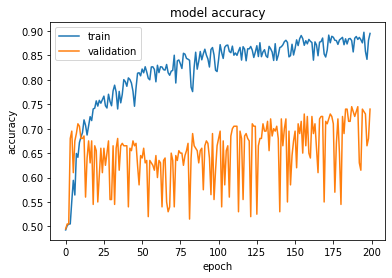

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


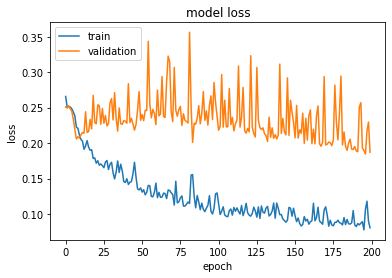

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

우리 프로젝트에 활용하려면?

- 훈련된 모델을 h5파일로 전환

- 실시간 영상 데이터를 20 프레임 단위로 쪼개어(프레임 resizing도 필요)

  VGG16층의 15층까지의 층을 거쳐 (20, 4096)크기의 전이 값 텐서로 전환해야 
  
  우리가 만든 모델에 제공돼서 predict할 수 있다.

  (실시간으로 할 수 있을까? 할 수 없다면 속도(반응)은 느리겠지만 어떻게 해야 
  
  하는가?)

- 어떤 프로그램 로직을 통해 챗봇 알림을 보낼 것인가?

- 영상화면에 폭력이 감지되었다는 것을 어떻게 비주얼 적으로 표현해 주는 것

  주의사항

- 그래프를 통해 알 수 있는 것은 epoch 23쯤부터 과적합이 발생한다는 것->최적화 

  시키자.=>(코드 오류를 수정하니 과적합이 발생하지 않았다)

- 프로젝트 발표 때 마지막 LSTM단의 사용 이유에 대해 정확히(애매모호하지 않게) 

  말할 수 있도록 제반 지식이 있다면 좋을 것 같다.

- 데이터만 바뀌면 다른 주제로 얼마든지 전향 가능하지 않을까? (ex 충돌 감지)

### 모델 저장 및 weights 저장

In [43]:
model_json = model.to_json()
# Save model with json format
with open("violence_detection_model.json","w") as json_file:
    json_file.write(model_json)

# Save weight with h5 format
model.save_weights("violence_detection_model.h5")